In [1]:
pip install pydicom

In [2]:
import pydicom as dicom
import zipfile
from io import StringIO
from PIL import Image
import imghdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from tensorflow.keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
# specify your image path
#read train images 
dir_name = r"/content/drive/MyDrive/stage_2_train_images"


df_dicom_data_train = pd.DataFrame(columns = ['Pixel Data','Patient Name','patientId','Patient Sex','Patient Age',
                                             'Body Part Examined','View Position'])

count = 0
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
for subdir, dirs, files in os.walk(dir_name):
    print(len(files))
    for file in files:
        count = count + 1
        file_path = os.path.join(subdir, file)
        
        ds = dicom.dcmread(file_path)
        
        img = cv2.resize(ds.pixel_array, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
        df_dicom_data_train = df_dicom_data_train.append({'Pixel Data':img,'Patient Name':ds.PatientName ,'patientId':ds.PatientID,
                                                            'Patient Sex':ds.PatientSex,'Patient Age':ds.PatientAge,
                                                            'Body Part Examined':ds.BodyPartExamined  ,'View Position':ds.ViewPosition},ignore_index=True)
        
        


26684


In [7]:
df_dicom_data_trainDF = df_dicom_data_train[df_dicom_data_train.duplicated(['patientId'])]
df_dicom_data_trainDF.shape
#There are no duplicates patient id entries in the dycom records

(0, 7)

In [8]:
#Read class info
dir_name = r"/content/drive/MyDrive/stage_2_detailed_class_info.csv"

df_class_info = pd.read_csv(dir_name)
df_class_info.head(5)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
df_class_infoDF = df_class_info[df_class_info.duplicated()]
df_class_infoDF.shape
#There are 3543 duplicates rows in class information hence those can be deleted

(3543, 2)

In [10]:
#Read train labels 
dir_name = r"/content/drive/MyDrive/stage_2_train_labels.csv"

df_train_labels = pd.read_csv(dir_name)
df_train_labels.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [11]:
df_train_labelsDF = df_train_labels[df_train_labels.duplicated()]
df_train_labelsDF.shape
#There are no duplicates rows in the labels

(0, 6)

In [12]:
df_train_labelsDF = df_train_labels[df_train_labels.duplicated('patientId')]
print(df_train_labelsDF.shape)
df_train_labels.sort_values(by=['patientId'])
#There are 3543 duplicates patient id rows in the labels which means one patient has had many X-rays done with different bounding box values as shown below
#However, since bonding box values are different so we can keep them as training data

(3543, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1
...,...,...,...,...,...,...
28984,fffb2395-8edd-4954-8a89-ffe2fd329be3,641.0,473.0,201.0,309.0,1
28985,fffba05a-1635-4545-9bbd-57ad4cfe8d27,NaN,NaN,NaN,NaN,0
28986,fffc95b5-605b-4226-80ab-62caec682b22,NaN,NaN,NaN,NaN,0
28987,fffcff11-d018-4414-971a-a7cefa327795,NaN,NaN,NaN,NaN,0


In [13]:
print('Training Label Shape &','Class Info Shape',df_train_labels.shape,df_class_info.shape)

Training Label Shape & Class Info Shape (30227, 6) (30227, 2)


In [14]:
#Find count of patient ids common in training labels and class info
len(pd.Series(df_train_labels.patientId.isin(df_class_info.patientId).values.astype(int), df_train_labels.patientId.values))

30227

In [15]:
#Find count of patient ids common in training labels and class info
len(pd.Series(df_class_info.patientId.isin(df_train_labels.patientId).values.astype(int), df_class_info.patientId.values))

30227

In [16]:
ctab1 = pd.crosstab(df_class_info.patientId,df_class_info['class'])
ctab1

class,Lung Opacity,No Lung Opacity / Not Normal,Normal
patientId,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1,0
000924cf-0f8d-42bd-9158-1af53881a557,0,0,1
000db696-cf54-4385-b10b-6b16fbb3f985,2,0,0
000fe35a-2649-43d4-b027-e67796d412e0,2,0,0
001031d9-f904-4a23-b3e5-2c088acd19c6,2,0,0
...,...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,2,0,0
fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,0,1
fffc95b5-605b-4226-80ab-62caec682b22,0,1,0


In [17]:

#Create new column to indicate if any patient has multi class entries
ctab1['Multiple_Class'] = ctab1.apply(lambda row: True if ((row['Lung Opacity'] > 0 and row['No Lung Opacity / Not Normal'] > 0) or 
                                                           (row['Normal'] > 0 and row['No Lung Opacity / Not Normal'] > 0) or 
                                                           (row['Normal'] > 0 and row['Lung Opacity'] > 0)) else False,axis=1)


ctab1[ctab1['Multiple_Class']==True]

#No multi class entry present for any patient

class,Lung Opacity,No Lung Opacity / Not Normal,Normal,Multiple_Class
patientId,,,,


In [18]:
ctab2 = pd.crosstab(df_train_labels.patientId,df_train_labels['Target'])
ctab2


Target,0,1
patientId,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,1,0
000924cf-0f8d-42bd-9158-1af53881a557,1,0
000db696-cf54-4385-b10b-6b16fbb3f985,0,2
000fe35a-2649-43d4-b027-e67796d412e0,0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,0,2
...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,0,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,1,0
fffc95b5-605b-4226-80ab-62caec682b22,1,0


In [19]:
ctab2

Target,0,1
patientId,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,1,0
000924cf-0f8d-42bd-9158-1af53881a557,1,0
000db696-cf54-4385-b10b-6b16fbb3f985,0,2
000fe35a-2649-43d4-b027-e67796d412e0,0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,0,2
...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,0,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,1,0
fffc95b5-605b-4226-80ab-62caec682b22,1,0


In [20]:

#Create new column to indicate if any patient has multiple values for target
ctab2['Multiple_Target'] = ctab2.apply(lambda row: True if (row[0] > 0 and row[1] > 0) else False,axis=1)


ctab2[ctab2['Multiple_Target']==True]

#No multi target entry present for any patient

Target,0,1,Multiple_Target
patientId,,,


In [21]:
df_train_labels_class = pd.merge(df_train_labels , df_class_info,on='patientId' )


In [22]:
df_train_labels_class

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
37624,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37626,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37627,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1,Lung Opacity


In [23]:
x1=df_train_labels_class[df_train_labels_class['Target']==1]['x'].isna()
print(x1.value_counts())

x1=df_train_labels_class[df_train_labels_class['Target']==0]['x'].isna()
print(x1.value_counts())

#There are no entries where target =1 and bounding box is not present. Vice versa, there are no entries where target = 0 and bounding box is present

False    16957
Name: x, dtype: int64
True    20672
Name: x, dtype: int64


In [24]:
df_train_labels_class[df_train_labels_class['Target']==1]['class'].value_counts()
#Only class 'Lung Opacity' has target value as 1

Lung Opacity    16957
Name: class, dtype: int64

In [25]:
df_dicom_data_train.head(5)

,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(f, 7, 9, e, 5, a, 7, 5, -, 5, e, 1, 5, -, 4, ...",f79e5a75-5e15-431a-9ba3-de64c1724b65,M,59,CHEST,PA
1,"[[12, 11, 12, 12, 12, 12, 12, 11, 11, 11, 11, ...","(f, 7, 9, f, a, 9, 4, e, -, 8, 8, 8, 6, -, 4, ...",f79fa94e-8886-425c-95d4-81abfea92aee,F,43,CHEST,PA
2,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(f, 7, a, 1, 6, 9, e, 2, -, a, 1, a, 7, -, 4, ...",f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9,M,52,CHEST,PA
4,"[[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,...","(f, 7, a, 1, 7, 2, f, c, -, a, 3, 4, f, -, 4, ...",f7a172fc-a34f-4155-806d-7b0afe2a6156,M,26,CHEST,AP


In [26]:
#Merge dicom data with labels and class data

df_data = pd.merge(df_dicom_data_train,df_train_labels_class,how='left',on='patientId')

In [27]:
df_data['View Position'].value_counts()

AP    21817
PA    15812
Name: View Position, dtype: int64

In [28]:
df_data['Body Part Examined'].value_counts()

CHEST    37629
Name: Body Part Examined, dtype: int64

In [29]:
df_data.head(5)

,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position,x,y,width,height,Target,class
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(f, 7, 9, e, 5, a, 7, 5, -, 5, e, 1, 5, -, 4, ...",f79e5a75-5e15-431a-9ba3-de64c1724b65,M,59,CHEST,PA,NaN,NaN,NaN,NaN,0,Normal
1,"[[12, 11, 12, 12, 12, 12, 12, 11, 11, 11, 11, ...","(f, 7, 9, f, a, 9, 4, e, -, 8, 8, 8, 6, -, 4, ...",f79fa94e-8886-425c-95d4-81abfea92aee,F,43,CHEST,PA,NaN,NaN,NaN,NaN,0,Normal
2,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP,613.0,241.0,169.0,479.0,1,Lung Opacity
3,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP,613.0,241.0,169.0,479.0,1,Lung Opacity
4,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP,276.0,248.0,168.0,477.0,1,Lung Opacity


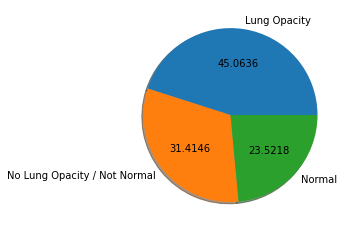

In [30]:
#Get class distribution
v_counts = df_data['class'].value_counts()
plt.pie(v_counts, labels=v_counts.index, autopct='%.4f', shadow=True);
plt.show()

#Data is fairly balanced with 45% pneumonia cases and 55% non-pneumonia cases

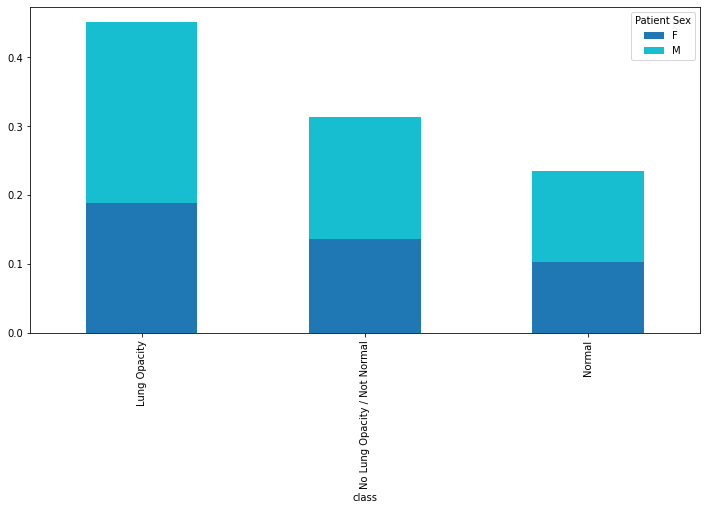

In [31]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['Patient Sex'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))
plt.show()
#All class seem to have slightly higher male distribution compared to females

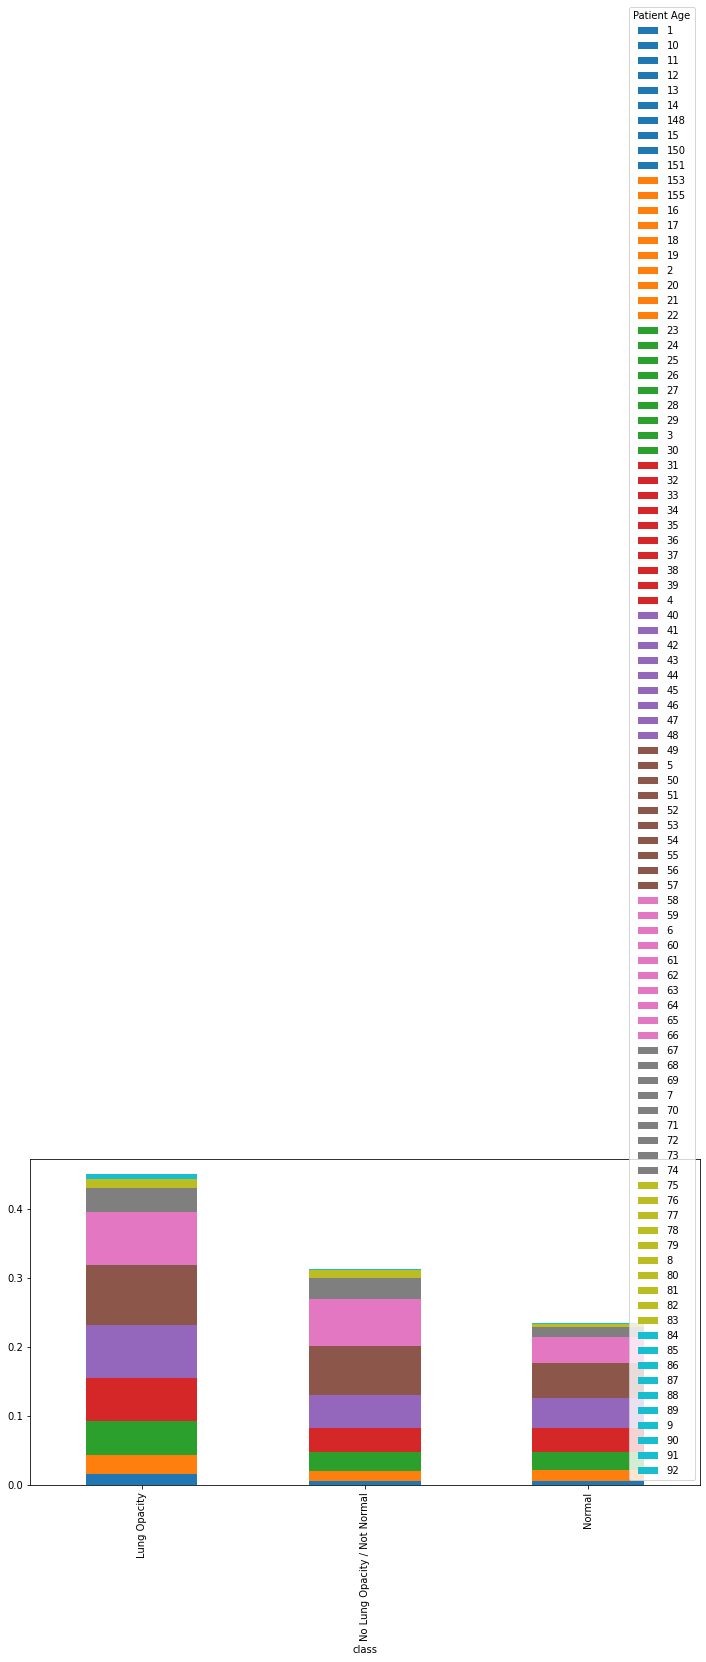

41


In [32]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['Patient Age'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))

plt.show()

#The age range 21-68 years seem to be most susceptible to pneumonia 

print(len(df_data[pd.to_numeric(df_data['Patient Age'])>=90]))
#41 records are with age >90 which is outlier and can be removed


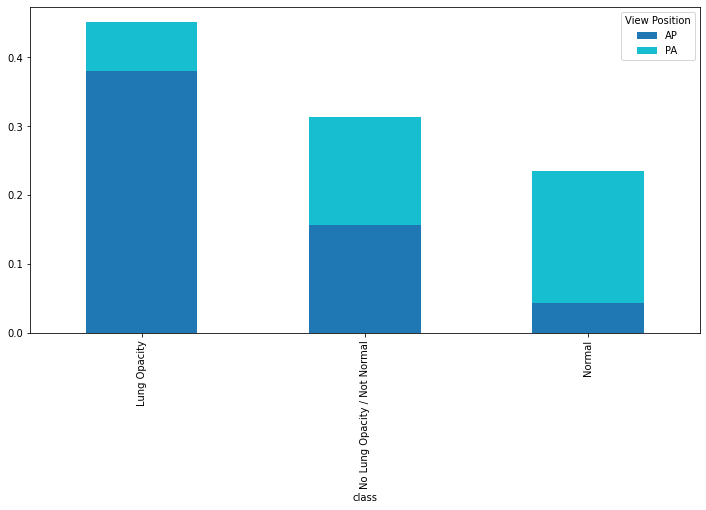

In [33]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['View Position'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))
plt.show()
#AP orientation seem to account for ~90% of pneumonia cases

#Data Observations
#1. There are no duplicate patient ids in dycom data
#2. There are duplicate patient ids in class info data with identical class data which can be removed
#3. There are duplicate patient ids in label data, however, the bounding box values are different indicating different set of x-day data for same patient hence cannot be considered as duplicate
#4. Data for patient with age > 100 are present which seems not correct and can be removed  
#5. There are no entries where target =1 and bounding box is not present. Vice versa, there are no entries where target = 0 and bounding box is present

In [34]:
df_dataDF = df_data[df_data.duplicated(['patientId','Patient Sex','Patient Age','Body Part Examined','View Position','x','y',
                                        'width','height','Target','class'])]

print('Duplicate Record Count: ', len(df_dataDF))

df_dataDF1 = df_dataDF.drop_duplicates(['patientId','Patient Sex','Patient Age','Body Part Examined','View Position','x','y',
                                        'width','height','Target','class'],keep = 'first') 
df_dataDF1[df_dataDF1['Target']==1].sort_values(by=['patientId'])

#Duplicates removed

Duplicate Record Count:  7402


,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position,x,y,width,height,Target,class
36479,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(0, 0, 0, d, b, 6, 9, 6, -, c, f, 5, 4, -, 4, ...",000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP,316.0,318.0,170.0,478.0,1,Lung Opacity
36481,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(0, 0, 0, d, b, 6, 9, 6, -, c, f, 5, 4, -, 4, ...",000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP,660.0,375.0,146.0,402.0,1,Lung Opacity
36485,"[[17, 18, 18, 18, 19, 19, 20, 20, 20, 20, 19, ...","(0, 0, 0, f, e, 3, 5, a, -, 2, 6, 4, 9, -, 4, ...",000fe35a-2649-43d4-b027-e67796d412e0,M,40,CHEST,AP,83.0,227.0,296.0,438.0,1,Lung Opacity
36483,"[[17, 18, 18, 18, 19, 19, 20, 20, 20, 20, 19, ...","(0, 0, 0, f, e, 3, 5, a, -, 2, 6, 4, 9, -, 4, ...",000fe35a-2649-43d4-b027-e67796d412e0,M,40,CHEST,AP,570.0,282.0,269.0,409.0,1,Lung Opacity
36489,"[[0, 0, 0, 0, 0, 0, 3, 30, 23, 24, 24, 24, 23,...","(0, 0, 1, 0, 3, 1, d, 9, -, f, 9, 0, 4, -, 4, ...",001031d9-f904-4a23-b3e5-2c088acd19c6,M,57,CHEST,PA,552.0,164.0,376.0,676.0,1,Lung Opacity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...","(f, f, a, 4, 2, 4, d, 2, -, 6, e, 6, b, -, 4, ...",ffa424d2-6e6b-4eed-93ab-7551e8941215,M,63,CHEST,AP,699.0,412.0,162.0,214.0,1,Lung Opacity
1195,"[[16, 4, 21, 6, 8, 8, 5, 5, 9, 29, 8, 9, 10, 5...","(f, f, d, 7, 8, 7, b, 6, -, 5, 9, c, a, -, 4, ...",ffd787b6-59ca-48cb-bd15-bcedd52cf37c,M,33,CHEST,AP,157.0,393.0,237.0,458.0,1,Lung Opacity
1197,"[[16, 4, 21, 6, 8, 8, 5, 5, 9, 29, 8, 9, 10, 5...","(f, f, d, 7, 8, 7, b, 6, -, 5, 9, c, a, -, 4, ...",ffd787b6-59ca-48cb-bd15-bcedd52cf37c,M,33,CHEST,AP,571.0,238.0,286.0,482.0,1,Lung Opacity
1216,"[[6, 4, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,...","(f, f, f, b, 2, 3, 9, 5, -, 8, e, d, d, -, 4, ...",fffb2395-8edd-4954-8a89-ffe2fd329be3,M,46,CHEST,AP,641.0,473.0,201.0,309.0,1,Lung Opacity


In [39]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

df_data1 = df_dataDF1[df_data['Target']==1]
masks = np.zeros((len(df_data1), IMAGE_HEIGHT, IMAGE_WIDTH))
masks_x1 = np.zeros(len(df_data1))
masks_x2 = np.zeros(len(df_data1))
masks_y1 = np.zeros(len(df_data1))
masks_y2 = np.zeros(len(df_data1))
X = np.zeros((len(df_data1),IMAGE_HEIGHT, IMAGE_WIDTH))

for index in range(0,len(df_data1)):
  if df_data1.iloc[index].at['Target'] == 1:

    img = df_data1.iloc[index].at['Pixel Data']
    X[index] = img
    # Loop through the face co-ordinates and create mask out of it.
    #print(index)
    x1 = int(df_data1.iloc[index].at['x']*IMAGE_WIDTH/1024)
    
    x2 = int((df_data1.iloc[index].at['x'] + df_data1.iloc[index].at['width'])*IMAGE_WIDTH/1024)
    
    y1 = int(df_data1.iloc[index].at['y']*IMAGE_HEIGHT/1024)  
    
    y2 = int((df_data1.iloc[index].at['y'] + df_data1.iloc[index].at['height'])*IMAGE_HEIGHT/1024)
    
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
    masks_x1[index] = x1
    masks_y1[index] = y1
    masks_x2[index] = x2
    masks_y2[index] = y2
    
    

print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Shape of X is '(6941, 224, 224)' and the shape of mask is '(6941, 224, 224)' 


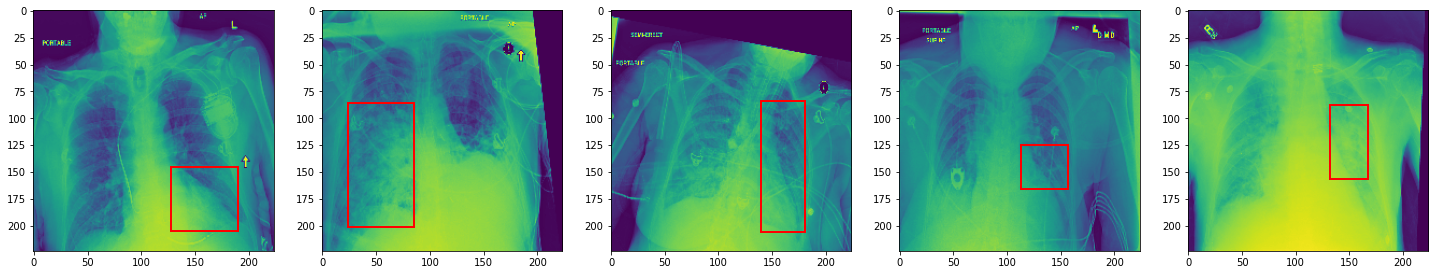

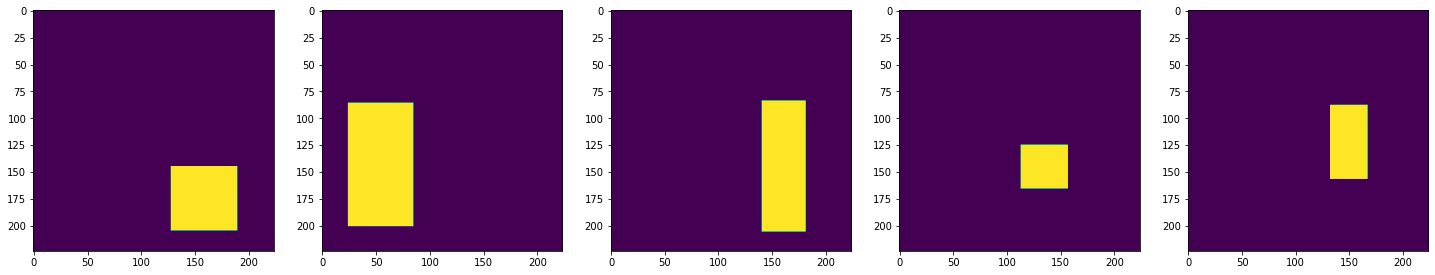

In [45]:
fig = plt.figure(figsize=(25, 25))

n = 5
idx1 = np.random.choice(len(df_data1), size=n)

count = 1
for i in idx1:
  
  ax = fig.add_subplot(1, 5, count)
  imgplot = plt.imshow(X[i])
  rect = patches.Rectangle((masks_x1[i],masks_y1[i]), masks_x2[i] - masks_x1[i], masks_y2[i] - masks_y1[i], linewidth=2, 
                           edgecolor='r', facecolor='none')
    
  # Add the patch to the Axes
  ax.add_patch(rect)
  
  count = count + 1

fig = plt.figure(figsize=(25, 25))

count = 1
for i in idx1:
  a = fig.add_subplot(1, 5, count)
  imgplot = plt.imshow(masks[i])
  count = count + 1


